In [1]:
import pandas as pd
import os as os
import csv
import time

In [2]:
df = pd.read_csv("./datasets/usa.csv")

In [3]:
df

,text,disaster,gpe
0,"Armed with a chainsaw and a charitable spirit,...",NaN,Florida
1,Its not raining yet but we know you are gettin...,thoughts,NaN
2,Irma has caused major damage in FL. They are i...,damage,NaN
3,As the work day in Haiti winds down CatholicRe...,shelter,Haiti
4,3Novices Devastating before and after photos o...,Devastating,NaN
...,...,...,...
1396,Healthcareworkers Florida has an immediate nee...,volunteers,Florida
1397,"Donate generously! FOX6, Salvation Army, iHear...","Relief, Disaster",NaN
1398,"Tim Duncan donates, pledges to match Hurricane...",relief,Duncan
1399,In Florida AnnaMariaIsland HurricaneIrmaAfterm...,NaN,Florida


In [4]:
import ollama
import re

def remove_before_think(text):
    return re.sub(r'^.*?</think>', '', text)

model = "deepseek-r1:1.5b"

def deepseek_response(prompt):
    response = ollama.chat(model=model, messages=[{"role": "user", "content": prompt}])
    content = response.message.content
    return re.sub(r'^.*?</think>\s*', '', content, flags=re.DOTALL)

In [5]:
df = df.dropna(subset=['gpe'])

In [6]:
df = df[:500]

In [7]:
df.to_csv("./datasets/usa.csv", index=False)

In [8]:
# Assume deepseek_response() is already defined
# def deepseek_response(text):
#     return "Some GPE response"  # Replace with actual LLM function

# CSV file path
csv_file = "./datasets/usa.csv"

# Read the existing CSV file
df = pd.read_csv(csv_file)

# Add new columns if not present
if "detected_gpe" not in df.columns:
    df["detected_gpe"] = ""
if "response_time" not in df.columns:
    df["response_time"] = ""

# Process each row and update detected_gpe and response_time
for index, row in df.iterrows():
    if pd.isna(row["detected_gpe"]) or row["detected_gpe"].strip() == "":
        text = row["text"]
        
        # Add instruction with a newline before the actual text
        prompt = f"Identify locations like country, city, or any local areas in the following sentence and write them in a comma-separated manner (no additional details required):\n\n{text}"
        
        start_time = time.time()  # Start timing
        detected_gpe = deepseek_response(prompt)  # Get LLM response
        end_time = time.time()  # End timing

        # Calculate response time
        response_time = round(end_time - start_time, 4)  # Rounded to 4 decimal places

        # Clean multiline response: strip spaces, join with commas if needed
        detected_gpe = ", ".join(line.strip() for line in detected_gpe.split("\n") if line.strip())

        # Update DataFrame
        df.at[index, "detected_gpe"] = detected_gpe
        df.at[index, "response_time"] = response_time

        # Save the updated row immediately to keep tracking progress
        df.to_csv(csv_file, index=False, quoting=csv.QUOTE_NONNUMERIC)

print("CSV file updated with detected GPE values and response times!")

CSV file updated with detected GPE values and response times!


In [19]:
df = pd.read_csv("./datasets/usa.csv")

In [10]:
df

,text,disaster,gpe,detected_gpe,response_time
0,"Armed with a chainsaw and a charitable spirit,...",NaN,Florida,"Florida, Hurricane Irma",6.6212
1,As the work day in Haiti winds down CatholicRe...,shelter,Haiti,"Haiti, those affected by Irma",5.5481
2,Florida Nursing Home Deaths After Irma Prompt ...,NaN,Florida,"Florida, New York",5.2608
3,"Boston Suffolk Co, MA AMATEUR RADIO reports FL...",FLOOD,"HAMILTON, COLUMBIA, Suffolk, Boston","Boston, Massachusetts; AMATEURRadio; Columba R...",4.9887
4,"My cousins house in Oakwood, Georgia damaged f...",NaN,"atlanta, Oakwood","Oakwood, GA, Atlanta, GA",3.7139
...,...,...,...,...,...
495,Recovery efforts pick up in Mexico after an 8....,"earthquake, magnitude, efforts",Mexico,Mexico,4.2341
496,Earthquake In China s Sichuan Province Kills A...,Earthquake,China,"China, Sichuan Province",5.2004
497,A look at the conditions in Cuba from Hurrican...,NaN,Cuba,"Cuba, Hurricane, Cuba",4.9062
498,Lightning sparks fires in Mendocino National F...,NaN,sparks,Mendocino National Forest,5.2973


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   text           500 non-null    object 
 1   disaster       306 non-null    object 
 2   gpe            500 non-null    object 
 3   detected_gpe   500 non-null    object 
 4   response_time  500 non-null    float64
dtypes: float64(1), object(4)
memory usage: 19.7+ KB


In [12]:
import tiktoken  # Ensure tiktoken is installed

# Assume deepseek_response() is already defined
# def deepseek_response(text):
#     return "Some GPE response"  # Replace with actual LLM function

# Load tokenizer (using OpenAI's tokenizer as an example)
tokenizer = tiktoken.get_encoding("cl100k_base")  # Update if using another tokenizer


# Add new columns if not present
for col in ["query_tokens", "response_tokens"]:
    if col not in df.columns:
        df[col] = ""

# Process each row and update detected_gpe, response_time, and token counts
for index, row in df.iterrows():
    text = row["text"]
    detected_gpe = row["detected_gpe"]
    prompt = f"Identify locations like country, city, or any local areas in the following sentence and write them in a comma-separated manner (no additional details required):\n\n{text}"
    # Token count using DeepSeek's tokenizer
    query_tokens = len(tokenizer.encode(prompt))
    response_tokens = len(tokenizer.encode(detected_gpe))

    df.at[index, "query_tokens"] = query_tokens
    df.at[index, "response_tokens"] = response_tokens

    # Save the updated row immediately to keep tracking progress
    df.to_csv(csv_file, index=False, quoting=csv.QUOTE_NONNUMERIC)

print("CSV file updated with detected GPE values, response times, and token counts!")


CSV file updated with detected GPE values, response times, and token counts!


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   text             500 non-null    object 
 1   disaster         306 non-null    object 
 2   gpe              500 non-null    object 
 3   detected_gpe     500 non-null    object 
 4   response_time    500 non-null    float64
 5   query_tokens     500 non-null    object 
 6   response_tokens  500 non-null    object 
dtypes: float64(1), object(6)
memory usage: 27.5+ KB


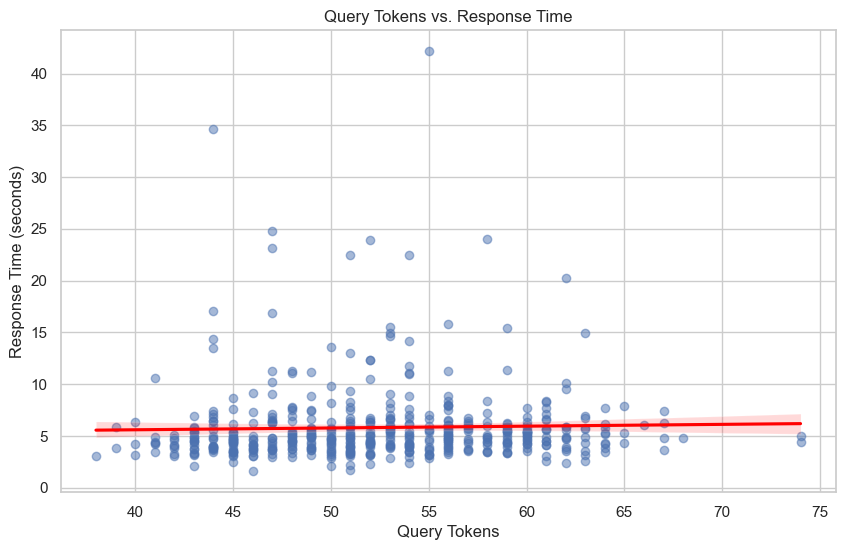

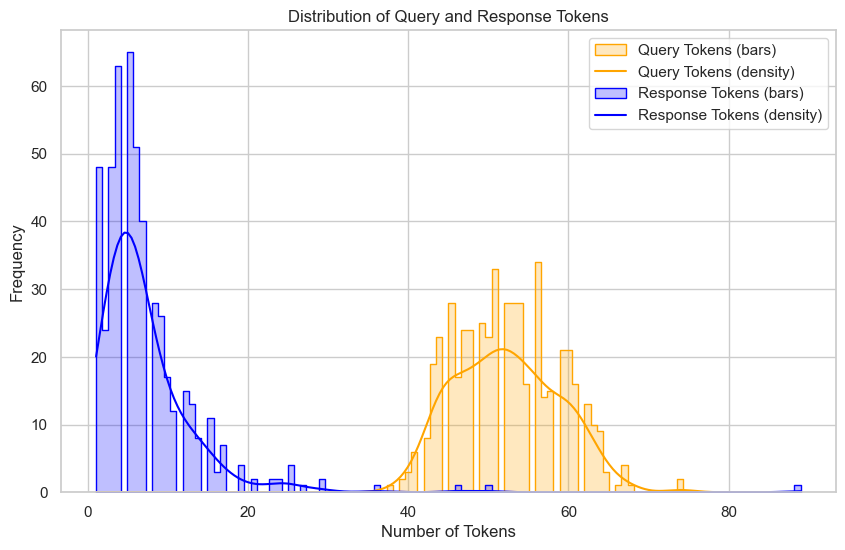

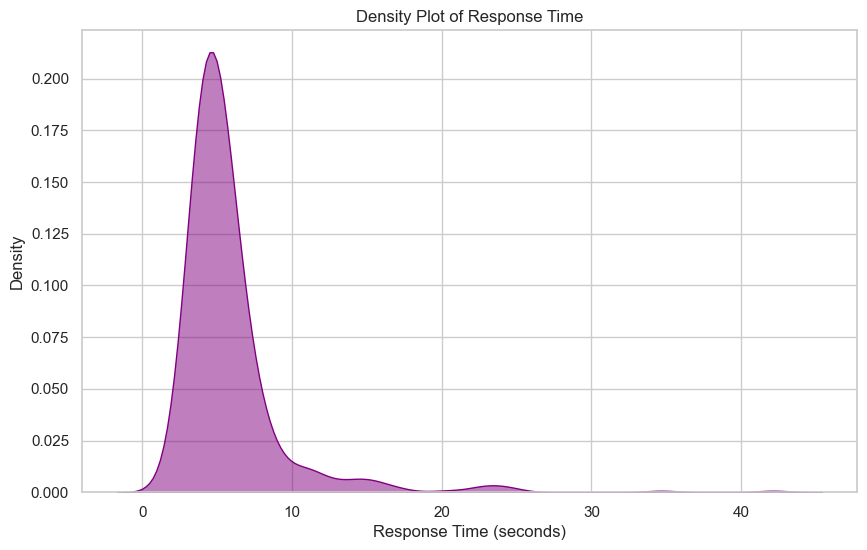

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CSV file path
csv_file = "./datasets/usa.csv"

# Read the CSV file
df = pd.read_csv(csv_file)

# Convert columns to numeric (in case they were mistakenly read as object)
df["query_tokens"] = pd.to_numeric(df["query_tokens"], errors="coerce")
df["response_tokens"] = pd.to_numeric(df["response_tokens"], errors="coerce")
df["response_time"] = pd.to_numeric(df["response_time"], errors="coerce")

# Set plot style
sns.set_theme(style="whitegrid")

# Figure 1: Scatter Plot (Query Tokens vs. Response Time)
plt.figure(figsize=(10, 6))
sns.regplot(x=df["query_tokens"], y=df["response_time"], scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
plt.xlabel("Query Tokens")
plt.ylabel("Response Time (seconds)")
plt.title("Query Tokens vs. Response Time")
plt.show()

# Figure 2: Bar Chart (Query Tokens vs. Response Tokens)
plt.figure(figsize=(10, 6))
sns.histplot(df[["response_tokens", "query_tokens"]], bins=114, kde=True, element="step", palette=["blue", "orange"])
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.title("Distribution of Query and Response Tokens")
plt.legend(["Query Tokens (bars)", "Query Tokens (density)","Response Tokens (bars)", "Response Tokens (density)"])
plt.show()

# Figure 3: Density Plot (Response Time Distribution)
plt.figure(figsize=(10, 6))
sns.kdeplot(df["response_time"], fill=True, color="purple", alpha=0.5)
plt.xlabel("Response Time (seconds)")
plt.ylabel("Density")
plt.title("Density Plot of Response Time")
plt.show()


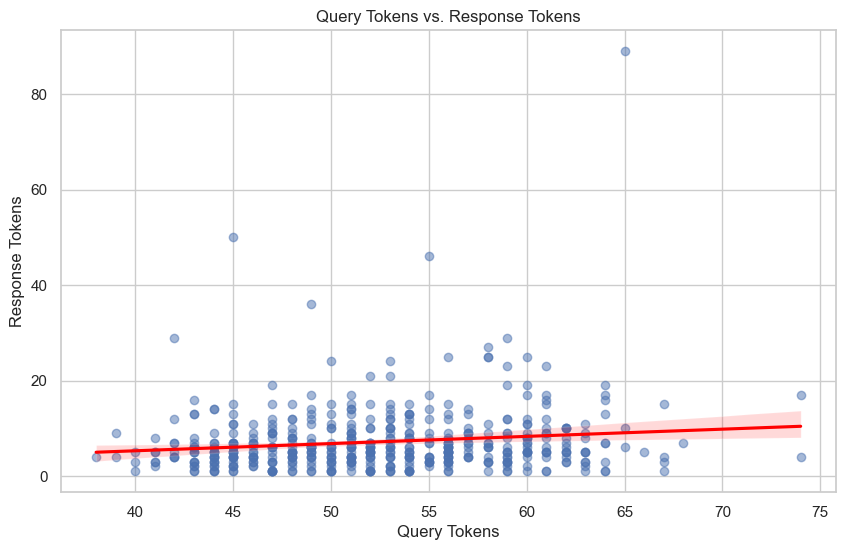

In [21]:
plt.figure(figsize=(10, 6))
sns.regplot(x=df["query_tokens"], y=df["response_tokens"], scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
plt.xlabel("Query Tokens")
plt.ylabel("Response Tokens")
plt.title("Query Tokens vs. Response Tokens")
plt.show()

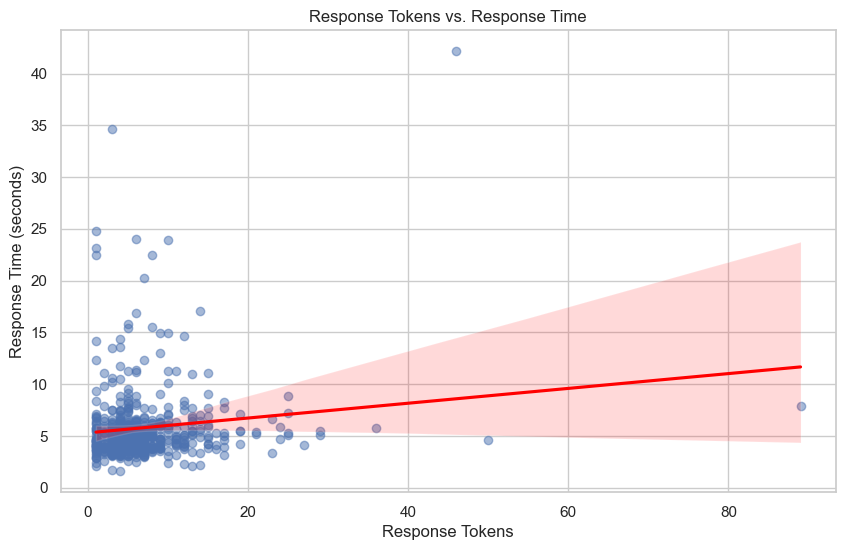

In [22]:
plt.figure(figsize=(10, 6))
sns.regplot(x=df["response_tokens"], y=df["response_time"], scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
plt.xlabel("Response Tokens")
plt.ylabel("Response Time (seconds)")
plt.title("Response Tokens vs. Response Time")
plt.show()

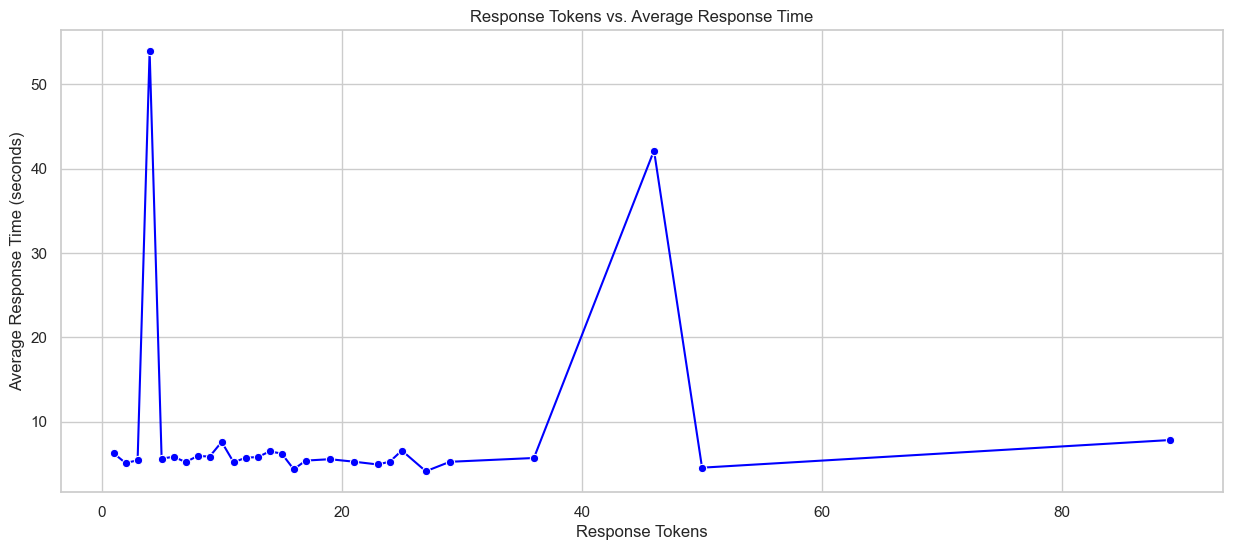

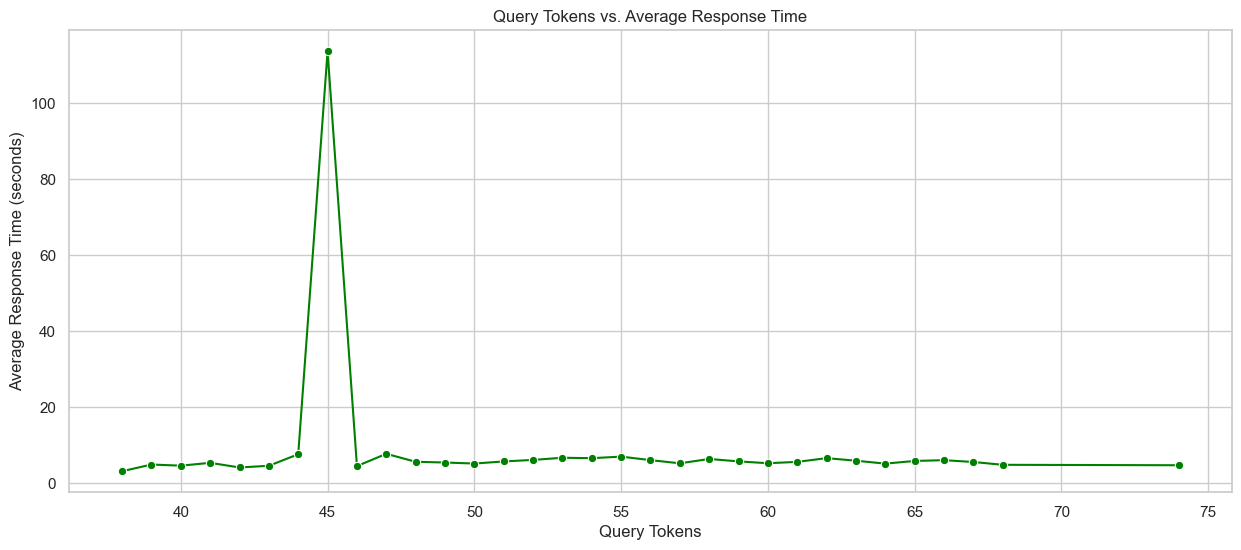

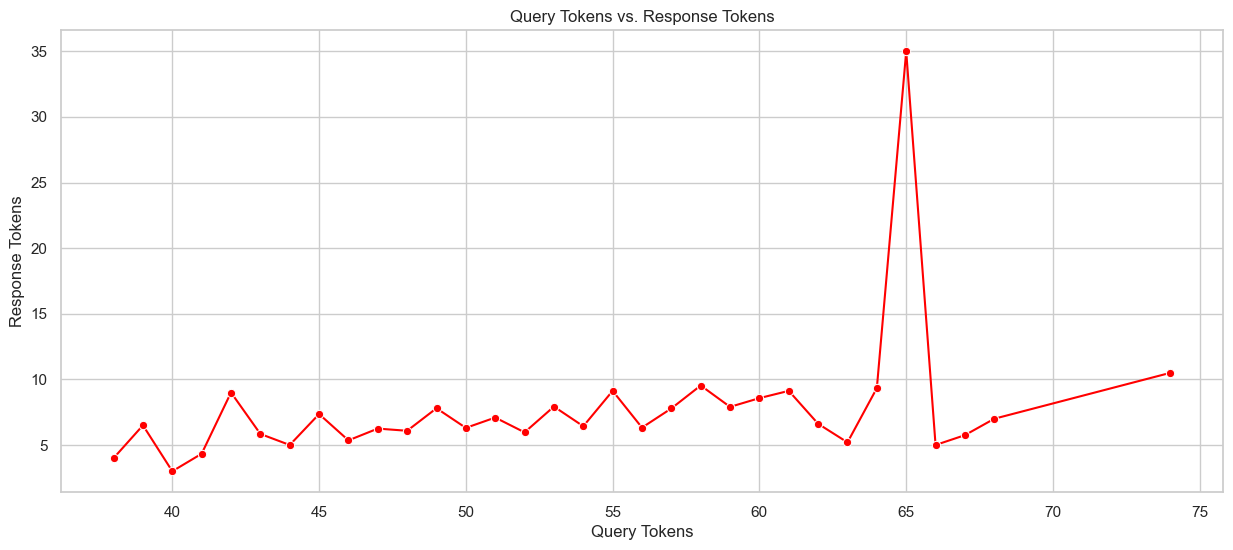

In [17]:
avg_response_time_r = df.groupby("response_tokens")["response_time"].mean().reset_index()
avg_response_time_q = df.groupby("query_tokens")["response_time"].mean().reset_index()
avg_response_tokens = df.groupby("query_tokens")["response_tokens"].mean().reset_index()
# Set plot style
sns.set_theme(style="whitegrid")

# Plot: Response Tokens vs. Average Response Time
plt.figure(figsize=(15, 6))
sns.lineplot(x=avg_response_time_r["response_tokens"], y=avg_response_time_r["response_time"], marker="o", color="blue")
plt.xlabel("Response Tokens")
plt.ylabel("Average Response Time (seconds)")
plt.title("Response Tokens vs. Average Response Time")
plt.show()

plt.figure(figsize=(15, 6))
sns.lineplot(x=avg_response_time_q["query_tokens"], y=avg_response_time_q["response_time"], marker="o", color="green")
plt.xlabel("Query Tokens")
plt.ylabel("Average Response Time (seconds)")
plt.title("Query Tokens vs. Average Response Time")
plt.show()

plt.figure(figsize=(15, 6))
sns.lineplot(x=avg_response_tokens["query_tokens"], y=avg_response_tokens["response_tokens"], marker="o", color="red")
plt.xlabel("Query Tokens")
plt.ylabel("Response Tokens")
plt.title("Query Tokens vs. Response Tokens")
plt.show()

In [18]:
df

,text,disaster,gpe,detected_gpe,response_time,query_tokens,response_tokens
0,"Armed with a chainsaw and a charitable spirit,...",NaN,Florida,"Florida, Hurricane Irma",6.6212,53,4
1,As the work day in Haiti winds down CatholicRe...,shelter,Haiti,"Haiti, those affected by Irma",5.5481,61,8
2,Florida Nursing Home Deaths After Irma Prompt ...,NaN,Florida,"Florida, New York",5.2608,48,4
3,"Boston Suffolk Co, MA AMATEUR RADIO reports FL...",FLOOD,"HAMILTON, COLUMBIA, Suffolk, Boston","Boston, Massachusetts; AMATEURRadio; Columba R...",4.9887,74,17
4,"My cousins house in Oakwood, Georgia damaged f...",NaN,"atlanta, Oakwood","Oakwood, GA, Atlanta, GA",3.7139,62,8
...,...,...,...,...,...,...,...
495,Recovery efforts pick up in Mexico after an 8....,"earthquake, magnitude, efforts",Mexico,Mexico,4.2341,53,1
496,Earthquake In China s Sichuan Province Kills A...,Earthquake,China,"China, Sichuan Province",5.2004,51,6
497,A look at the conditions in Cuba from Hurrican...,NaN,Cuba,"Cuba, Hurricane, Cuba",4.9062,43,6
498,Lightning sparks fires in Mendocino National F...,NaN,sparks,Mendocino National Forest,5.2973,43,6
